<div style='text-align: center;'>
<img src="images/math60082-banner.png" alt="image" width="80%" height="auto">
</div>

# Lab Workbook - Week 6

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import exp, sqrt

prng = np.random.default_rng(seed=8675309)

In [2]:
# stock parameters
S_0 = 98.31 # initial stick price
q = 0.01 # dividend yield

# call option contract parameters
X = 100 # strike price
T = 1.0 # time to expiry

# market parameters
r = 0.03 # risk free interest rate

# model parameters
kappa_nu = 1.5 # mean reversion parameter
theta_nu = 0.06 # long term value of the variance
nu_0 = 0.04 # initial variance
xi_nu = 0.4 # so called volatility of volatility
rho = -0.5 # correlation

N=1000 # paths
K=200 # points per path

dt = T/K

In [3]:
# Construct the Wiener processes
meanVec = np.zeros(2)
varCovarMat = np.array( [[dt , rho*dt], [rho*dt , dt]] )
dW1 , dW2 = prng.multivariate_normal( meanVec,  varCovarMat, size = (K,N)).T 

# Allocate storage for a single path's worth of t, S and nu values
time = np.zeros(K+1)
S_t = np.zeros(K+1)
nu_t = np.zeros(K+1)

# reset the paths by initialising first value
S_t[0] = S_0
nu_t[0] = nu_0

# path number
i=0
for k in range(0,K):
    nu_sqrt = sqrt(nu_t[k])
    time[k+1] = (k+1)*dt
    S_t[k+1] = S_t[k] + (r-q)*S_t[k]*dt + nu_sqrt*S_t[k]*dW1[i][k]
    nu_t[k+1] = nu_t[k] + kappa_nu*(theta_nu - nu_t[k])*dt + xi_nu*nu_sqrt*dW2[i][k]
    


# Tasks

1. Run the code for path $i=1,2,...$ and plot them on the graph -- do you encounter any problems?

Yes. The volatility goes negative and so `np.sqrt()` borks.

2. If $\nu_t<0$ is causing problems, include a *reflecting boundary condition* in your path calculation. That is, say
$$\nu^{k+1} =\left\{ \begin{array}{cc}
\nu^k +\kappa(\theta-\nu^k)\Delta t + \xi \sqrt{\nu^k} \Delta W_2 &\text{ if } \quad \nu^k + d\nu^k \geq 0\\
-(\nu^k +\kappa(\theta-\nu^k)\Delta t + \xi \sqrt{\nu^k} \Delta W_2) &\text{ if }\quad \nu^k + d\nu^k < 0
\end{array}\right.
$$  


In [4]:
from math import sqrt 

# Set up storage for all the paths.
# We'll put them in rows.
N=1000 # paths
K=200 # points per path

S_mat = np.zeros((N, K+1))
nu_mat = np.zeros((N, K+1))

# Do the times once and for all
dt = T / K
time = np.array( [j*dt for j in range(K+1)] )

# Construct paths, taking care to eneforce the reflecting boundary
for i in range(N): # loop over paths
    S_mat[i,0] = S_0
    nu_mat[i,0] = nu_0
    for k in range(K): # loop over times
        sqrt_nu = sqrt(nu_mat[i,k])
        S_mat[i,k+1] = S_mat[i,k] + (r-q)*S_mat[i,k]*dt + sqrt_nu*S_mat[i,k]*dW1[i,k]
        nu_mat[i,k+1] = nu_mat[i,k] + kappa_nu*(theta_nu - nu_mat[i,k])*dt + xi_nu*sqrt_nu*dW2[i,k]
        if nu_mat[i,k+1] < 0:
            # Reflect off the boundary at nu=0
            nu_mat[i,k+1] = -nu_mat[i,k+1]

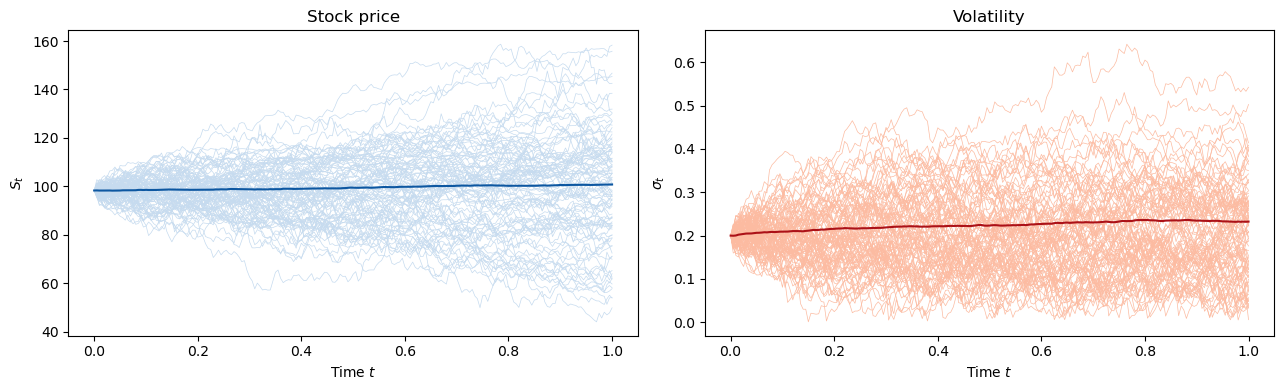

In [5]:
# Plot those puppies. 
# Begin by getting a couple of pleasing palettes
nShades = 10 
midPts = np.linspace( start=0.5/nShades, stop=(1.0 - 0.5/nShades), num=nShades )

red_cmap = plt.colormaps["Reds"]
red_pal = red_cmap(midPts)

blue_cmap = plt.colormaps["Blues"]
blue_pal = blue_cmap(midPts)

# Set the plot's dimensions
goldenMean = (1.0 + sqrt(5.0))/2.0
heightInInches = 4
widthInInches = 2 * goldenMean * heightInInches
myFig = plt.figure(figsize=(widthInInches, heightInInches)) 

# Choose a subsample of the traces
nTraces = 100
traceNum = prng.choice( N, size=nTraces, replace=False )

# Plot the stock prices
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
for i in range(nTraces):
    plt.plot(time, S_mat[traceNum[i],], color=blue_pal[2], linewidth=0.5)

meanS = np.mean( S_mat, axis=0 )
plt.plot(time, meanS, color=blue_pal[8])
plt.title('Stock price')
plt.xlabel( "Time $t$" )
plt.ylabel( "$S_t$" )

# Plot the volatility
plt.subplot(1, 2, 2)
for i in range(nTraces):
    plt.plot(time, np.sqrt(nu_mat[traceNum[i],]), color=red_pal[2], linewidth=0.5)

meanNu = np.mean( nu_mat, axis=0 )
plt.plot(time, np.sqrt(meanNu), color=red_pal[8])
plt.title('Volatility')
plt.xlabel( "Time $t$" )
plt.ylabel( "$\\sigma_t$" )
    
# Save the figure
myFig.tight_layout()
plt.savefig('Figures/StochasticVolatility.pdf', format='pdf', bbox_inches='tight')        

3. Simulate $N$ paths and calculate the average payoff of a call option to estimate the call option value

In [6]:
# Bundle up the code that generates paths and try to accelerate it with numba
# Here I write my own function to generate dW1 and dW2 as numba doesn't
# seem to support NumPy's multivariate normal
from numba import njit

@njit
def makeWienerProcesses( N, K, rho, dt, rng):
    # Begin by sampling two sets of i.i.d. standard normals
    phi1 = rng.normal( 0.0 , 1.0 , size = (N,K) )
    phi2 = rng.normal( 0.0 , 1.0 , size = (N,K) )
    
    # Form suitably weighted linear combinations of the phis
    # so as to get corelated variables
    dW1 = np.zeros((N,K))
    dW2 = np.zeros((N,K))
    
    sqrt_dt = np.sqrt(dt)
    dW1 = sqrt_dt * phi1
    dW2 = rho*sqrt_dt*phi1 + sqrt_dt*np.sqrt(1-rho*rho)*phi2

    return dW1, dW2
    
@njit
def generatePaths( N, K, S_0, q, r, X, T, kappa_nu, theta_nu, nu_0, xi_nu, rho, rng ):
    # Compute the time step
    dt = T / K
    
    # Generate realisations of the Wiener processes
    dW1, dW2 = makeWienerProcesses( N, K, rho, dt, rng )
    
    # Set up storage for all the paths.
    # We'll put them in rows.
    S_mat = np.zeros((N, K+1))
    nu_mat = np.zeros((N, K+1))

    # Solve the SDEs approximately
    for i in range(N): # loop over paths
        S_mat[i,0] = S_0
        nu_mat[i,0] = nu_0
        for k in range(K): # loop over times
            sqrt_nu = sqrt(nu_mat[i,k])
            S_mat[i,k+1] = S_mat[i,k] + (r-q)*S_mat[i,k]*dt + sqrt_nu*S_mat[i,k]*dW1[i,k]
            nu_mat[i,k+1] = nu_mat[i,k] + kappa_nu*(theta_nu - nu_mat[i,k])*dt + xi_nu*sqrt_nu*dW2[i,k]
            if nu_mat[i,k+1] < 0:
                # Reflect off the boundary at nu=0
                nu_mat[i,k+1] = -nu_mat[i,k+1]

    return S_mat, nu_mat

# Do a small test
generatePaths( 2, 3, S_0, q, r, X, T, kappa_nu, theta_nu, nu_0, xi_nu, rho, prng )

(array([[ 98.31      ,  81.38102054,  80.91772754,  80.31817115],
        [ 98.31      ,  85.13004153, 101.48602446, 104.50140246]]),
 array([[0.04      , 0.02118643, 0.07182737, 0.00879266],
        [0.04      , 0.08005715, 0.10164396, 0.1150846 ]]))

In [7]:
from math import exp

# Given paths of stock price, get the expected value of the option
@njit
def expectedOptionValue( S_mat, X, T, r ):
    N = S_mat.shape[0]
    
    valueSum = 0.0 
    for i in range(N):
        valueSum += max( S_mat[i,-1] - X, 0.0 )
        
    return (valueSum/N) * exp(-r*T)
        
# Do this for this for the paths generated above
expectedOptionValue( S_mat, X, T, r )

8.532648081972699

4. Analyse the results for different values of $N$ and $K$, what can you say about the effect of increasing or decreasing each of the numerical parameters?

In general, one expects the distribution of computed values of $S(T)$ to converge to the correct shape (as a distribution) as $K \rightarrow \infty$ and, provided that $K$ is large enough, the estimate of the expected payoff should converge, in the usual $\sqrt{N}$ way, as $N \rightarrow \infty$. In the next section I'll fix $N$ and vary $K$, then fix a largish $K$ and vary $N$.

In [8]:
Kvals = [200 * int(pow(2,k)) for k in range(10)]
print( Kvals )
nKvals = len(Kvals)

[200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400]


In [9]:
N = 1000 
repsPerVal = 100
K_resultMat = np.zeros( (nKvals, repsPerVal) )
for i in range(nKvals):
    K = Kvals[i]
    for j in range(repsPerVal):
        S_mat, nu_mat = generatePaths( N, K, S_0, q, r, X, T, kappa_nu, theta_nu, nu_0, xi_nu, rho, prng )
        K_resultMat[i,j] = expectedOptionValue( S_mat, X, T, r )

In [10]:
import pandas as pd

# Look at summaries of the moments
K_result_df = pd.DataFrame( 
    {
        'K': Kvals,
        'Mean $C(S_0, t=0)$': np.mean( K_resultMat, axis=1 ), # does means across rows
        'SD $C(S_0, t=0)$': np.std( K_resultMat, axis=1 ) # does std. dev. across rows
    }
)

print( K_result_df )

        K  Mean $C(S_0, t=0)$  SD $C(S_0, t=0)$
0     200            8.257473          0.352550
1     400            8.209989          0.387943
2     800            8.356103          0.372370
3    1600            8.248039          0.403373
4    3200            8.204559          0.409214
5    6400            8.261147          0.372491
6   12800            8.289506          0.386990
7   25600            8.227562          0.407077
8   51200            8.267729          0.376128
9  102400            8.276876          0.391157


As one would expect, the mean settles down as $K$ increases.

In [11]:
Nvals = [1000 * int(pow(2,k)) for k in range(8)]
print( Nvals )
nNvals = len(Nvals)

[1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000]


In [12]:
K = 5000 
repsPerVal = 100
N_resultMat = np.zeros( (nNvals, repsPerVal) )
for i in range(nNvals):
    N = Nvals[i]
    for j in range(repsPerVal):
        S_mat, nu_mat = generatePaths( N, K, S_0, q, r, X, T, kappa_nu, theta_nu, nu_0, xi_nu, rho, prng )
        N_resultMat[i,j] = expectedOptionValue( S_mat, X, T, r )

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [13]:
# Look at summaries of the moments
N_result_df = pd.DataFrame( 
    {
        'N': Nvals,
        'Mean $C(S_0, t=0)$': np.mean( N_resultMat, axis=1 ), 
        'SD $C(S_0, t=0)$': np.std( N_resultMat, axis=1 ) 
    }
)

print( N_result_df )

        N  Mean $C(S_0, t=0)$  SD $C(S_0, t=0)$
0    1000            8.289012          0.393939
1    2000            8.252266          0.246644
2    4000            8.231894          0.185193
3    8000            8.239696          0.148929
4   16000            8.253275          0.094141
5   32000            8.266477          0.070533
6   64000            8.261807          0.050052
7  128000            8.263648          0.036063


5. For the model parameters: $S_0 = 98.31$, $q = 0.01$, $X = 100$, $T = 1$, $r=0.03$, $\kappa = 1.5$, $\theta = 0.06$, $\nu_0 = 0.04$, $\xi = 0.4$ and $\rho = -0.5 $ the analytic result found using a numerical library is $C(S_0,t=0)=8.2623461$.

What can you say about the errors of your Monte Carlo vs this value?

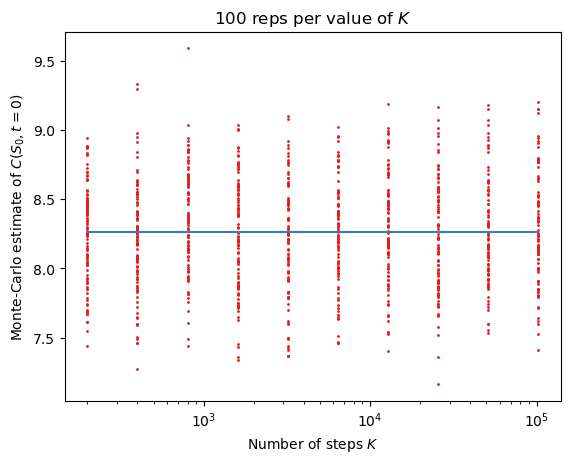

In [14]:
# Choose some pleasing colors from the Brewer palettes
# See https://colorbrewer2.org/
cmap = plt.colormaps["Set1"]
set_pal = cmap(range(0,9))

for i in range(nKvals):
    plt.semilogx( np.repeat(Kvals[i], repsPerVal), K_resultMat[i,:], color=set_pal[0], marker=".", markersize=2, linestyle='none' )
    
# Add a line running through the known result
trueResult = 8.2623461
plt.semilogx( np.array([Kvals[0], Kvals[-1]]), np.array([trueResult, trueResult]), color=set_pal[1] )
    
# Add titles
plt.xlabel( "Number of steps $K$" )
plt.ylabel( "Monte-Carlo estimate of $C(S_0, t=0)$" )
plt.title( f"{repsPerVal} reps per value of $K$" )

plt.savefig('Figures/MonteCarloHestonModel_K.pdf', format='pdf', bbox_inches='tight')

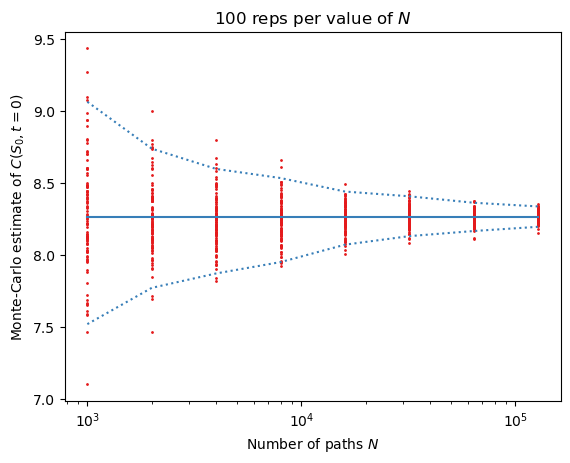

In [19]:
for i in range(nNvals):
    plt.semilogx( np.repeat(Nvals[i], repsPerVal), N_resultMat[i,:], color=set_pal[0], marker=".", markersize=2, linestyle='none' )
    
# Add a line running through the known result
trueResult = 8.2623461
plt.semilogx( np.array([Nvals[0], Nvals[-1]]), np.array([trueResult, trueResult]), color=set_pal[1] )

# Construct 95% confidence intervals
from scipy.stats import norm

mean_vs_N = np.mean( N_resultMat, axis=1 ) # does means across rows
sd_vs_N = np.std( N_resultMat, axis=1 ) # does std deviations across rows

conf = 0.95
alpha = 1.0 - conf
std_CI_halfWidth = norm.ppf(1.0 - 0.5*alpha) 

CI_lb = mean_vs_N - std_CI_halfWidth*sd_vs_N
CI_ub = mean_vs_N + std_CI_halfWidth*sd_vs_N

plt.semilogx( Nvals, CI_lb, color=set_pal[1], linestyle="dotted" )
plt.semilogx( Nvals, CI_ub, color=set_pal[1], linestyle="dotted" )
    
# Add titles
plt.xlabel( "Number of paths $N$" )
plt.ylabel( "Monte-Carlo estimate of $C(S_0, t=0)$" )
plt.title( f"{repsPerVal} reps per value of $N$" )

plt.savefig('Figures/MonteCarloHestonModel_N.pdf', format='pdf', bbox_inches='tight')

## Path Dependent Options

Assume that the stock price $S_t$ is observed at $K+1$ equally-spaced time points $t_0,t_1,\dots,t_K$ with $t_0=0$ and $t_K=T$. Now let us find the value of a path dependent option where
we define the underlying asset $A$ to be the average absolute movements in the share price over several periods such that
$$
A = \frac{\sum_{i=1}^K | S(t_i) - S(t_{i-1}) |}{\sqrt{K}} .
$$
Assuming the Black-Scholes framework under the risk-neutral measure, and we wish to price a call option with payoff 
$$
C(A,S,t=T)=\max(A-X,0).
$$ 

Find the value
$$
C(S_0,t=0) = e^{-rT} \mathbb{E}^Q[\max(A-X,0)]
$$
- where $K=20$, strike price $X=30$ and a maturity $T=1$ is one year from now;
- the current stock price is $S_0=104.81$;
- the stock price follows a GBM with $\sigma=0.4$, the interest rate is $r=0.03$.
 

In [20]:
# SDE parameters
S_0 = 104.82
sigma=0.4
r=0.03

# contract parameters
T=1.
X=30.
K=20

# numerical parameters
N=1000

6. Program your solution into a function

In [21]:
# Define a function to generate N paths, each of K steps, 
# and return the associated payoffs.

@njit
def estimateOptionVal( K, N, S_0, r, sigma, T, X, rng ):
    # Compute the timestep
    dt = T / K
    
    # Generate all Wiener process values - one per step per path -
    # at a stroke. We'll store them in a matrix whose rows correspond to paths.
    dW = rng.normal( 0.0 , np.sqrt(dt) , size = (N, K) )
    
    # Store the paths in a matrix, one path per row
    S_t = np.zeros( (N, K+1) ) 
    A_numerator_sum = np.zeros(N) # scrtach space
    payoff = np.zeros(N)
    
    # Construct the paths with Euler-Maruyama steps, accumulating
    # the numerator of A as we go. Here we work with whole columns
    # in a single step
    S_t[:,0] = S_0
    sigmaSq = sigma*sigma
    for k in range(K):
        # Extend all N paths from t_k to t_{k+1}
        S_t[:,k+1] = S_t[:,k] * np.exp((r-0.5*sigmaSq)*dt+sigma*dW[:,k])

        # Accumulate the numerators of the A's
        A_numerator_sum += np.fabs(S_t[:,k+1] - S_t[:,k])
    
    # Compute and store A
    A = A_numerator_sum / sqrt(K)
        
    # Now compute the payoff and return its discounted version
    payoff = np.maximum(A-X, 0.0)
    return exp( -r*T) * payoff

In [22]:
# Try a small example
K = 20
N = 10
estimateOptionVal( K, N, S_0, r, sigma, T, X, prng )

array([ 0.        ,  3.2946857 ,  0.        ,  5.84394624,  0.        ,
        0.        , 12.51628044, 12.99278139,  3.3471838 ,  0.        ])

7. Analyse the effect of $N$ and $K$ on your results

#### 7 (a) Effects of varying $N$

In [23]:
# Choose a range of sample sizes N
nSizes = 8
sampleSize = [1000*int(pow(2,j+1)) for j in range(nSizes)]
sampleSize

[2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000]

In [24]:
# Fix a value of K and then vary N
K = 20

# Assemble lots of reps at each sample size
repsPerSize=100
results_N = np.zeros((nSizes, repsPerSize))
for j in range(nSizes):
    N = sampleSize[j]
    for k in range(repsPerSize):
        discountedPayoffs = estimateOptionVal( K, N, S_0, r, sigma, T, X, prng )
        results_N[j,k] = np.mean( discountedPayoffs )

In [25]:
import pandas as pd
from scipy.stats import norm

# Construct 95% confidence intervals
mean_vs_N = np.mean( results_N, axis=1 ) # does means across rows
sd_vs_N = np.std( results_N, axis=1 ) # does std deviations across rows

conf = 0.95
alpha = 1.0 - conf
std_CI_halfWidth = norm.ppf(1.0 - 0.5*alpha) 

CI_lb = mean_vs_N - std_CI_halfWidth*sd_vs_N
CI_ub = mean_vs_N + std_CI_halfWidth*sd_vs_N

# Assemble the results into a nice table and display them
result_N_df = pd.DataFrame( {
    "$N$": sampleSize, 
    "Mean $V(t=0)$":mean_vs_N,
    "SD $V(t=0)$": sd_vs_N,
    "CI lower bound": CI_lb,
    "CI upper bound": CI_ub
})

print( result_N_df )

      $N$  Mean $V(t=0)$  SD $V(t=0)$  CI lower bound  CI upper bound
0    2000       5.766302     0.181396        5.410771        6.121832
1    4000       5.754470     0.136975        5.486003        6.022937
2    8000       5.738925     0.096859        5.549085        5.928764
3   16000       5.743735     0.062572        5.621097        5.866373
4   32000       5.744730     0.049771        5.647180        5.842280
5   64000       5.748501     0.032188        5.685415        5.811588
6  128000       5.749510     0.024223        5.702034        5.796987
7  256000       5.746058     0.016435        5.713846        5.778269


Note that increasing $N$ by a factor of 4 does, as expected, reduce the standard deviation by a factor of 2.

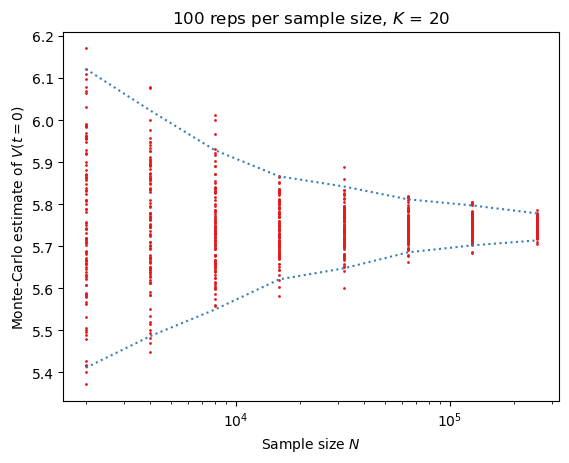

In [26]:
for j in range(nSizes):
    plt.semilogx( np.repeat(sampleSize[j], repsPerSize), results_N[j,:], color=set_pal[0], marker=".", markersize=2, linestyle='none' )
        
# Add dotted envelopes forming a 95% confidence band 
plt.semilogx( sampleSize, CI_lb, color=set_pal[1], linestyle="dotted" )
plt.semilogx( sampleSize, CI_ub, color=set_pal[1], linestyle="dotted" )

# Add titles
plt.xlabel( "Sample size $N$" )
plt.ylabel( "Monte-Carlo estimate of $V(t=0)$" )
plt.title( f"{repsPerSize} reps per sample size, $K$ = {K}" )

plt.show()

#### 7 (b) Effects of varying $K$

$A$ is given by
$$
A = \frac{\sum_{i=1}^K | S(t_i) - S(t_{i-1}) |}{\sqrt{K}},
$$
where the $S(t_i)$ come from an Euler-Maruyama scheme for $\log(S)$:
$$
S(t_{i}) = S(t_{i-1})  e^{(r-\sigma^2/2)\Delta t+ \sigma\sqrt{\Delta t}\phi_i}.
$$
Here $\phi_i$ is drawn from the standard normal and the time step is $\Delta t = T/K$.

In the limit of large $K$ (and thus small $\Delta t$) the exponential factor will be

$$
\begin{align}
    e^{(r-\sigma^2/2)\Delta t+ \sigma\sqrt{\Delta t}\phi_i}
       & \approx 1 + \sigma\sqrt{\Delta t}\phi_i + O(\Delta t) \\
       & \approx 1 + \sigma \phi_i \sqrt{T/K} + O(T/K)
\end{align}
$$
and so the differences in the numerator of $A$ will be $O(1/\sqrt{K})$. We might thus expect the distribution of $A$ to converge to something stable.

In [27]:
# Choose a range of values for K, the number of steps
numStepsK = [int(pow(2,j)) for j in range(1,13)]
num_K_vals = len(numStepsK)
numStepsK

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

In [28]:
# Fix a largish N, then see what happens as K varies
N = 8000

# Assemble lots of reps at each sample size
repsPerSize=100
results_K = np.zeros((num_K_vals, repsPerSize))
for j in range(num_K_vals):
    K = numStepsK[j]
    for k in range(repsPerSize):
        discountedPayoffs = estimateOptionVal( K, N, S_0, r, sigma, T, X, prng )
        results_K[j,k] = np.mean( discountedPayoffs )

In [29]:
# Consruct 95% confidence intervals
mean_vs_K = np.mean( results_K, axis=1 ) # does means across rows
sd_vs_K = np.std( results_K, axis=1 ) # does std deviations across rows

CI_lb = mean_vs_K - std_CI_halfWidth*sd_vs_K
CI_ub = mean_vs_K + std_CI_halfWidth*sd_vs_K

# Assemble the results into a nice table and display them
result_K_df = pd.DataFrame( {
    "$K$": numStepsK, 
    "Mean $V(t=0)$":mean_vs_K,
    "SD $V(t=0)$": sd_vs_K,
    "CI lower bound": CI_lb,
    "CI upper bound": CI_ub
})

print( result_K_df )

     $K$  Mean $V(t=0)$  SD $V(t=0)$  CI lower bound  CI upper bound
0      2       9.282955     0.202725        8.885622        9.680288
1      4       7.624080     0.164519        7.301629        7.946531
2      8       6.528636     0.110654        6.311759        6.745514
3     16       5.891123     0.102435        5.690354        6.091891
4     32       5.514664     0.085370        5.347342        5.681986
5     64       5.351643     0.073762        5.207071        5.496215
6    128       5.238988     0.074675        5.092627        5.385349
7    256       5.183480     0.076940        5.032680        5.334279
8    512       5.172643     0.078241        5.019294        5.325992
9   1024       5.155170     0.061234        5.035153        5.275187
10  2048       5.161210     0.070926        5.022199        5.300222
11  4096       5.143534     0.066253        5.013682        5.273387


8. There is no obvious analytic solution for the discrete case $K=20$ &mdash; are you able to estimate the error even if you don't know the real solution? 

See 7a above. By looking at convergence with increasing $N$, we can get some idea of how good our numerical estimate is. We can't however, be sure that the thing our estimates are converging *to* is correct without some other work. One might try special values of the parameters, where analytic solutions could be availabe.

9. Choosing the largest value of $N$ you can feasibly run given the calculation time, state a confidence interval for the result.

*See above.*